# Probabilistic Regression with Tensorflow 

https://ekamperi.github.io/machine%20learning/2021/01/07/probabilistic-regression-with-tensorflow.html

Stathis Kamperis, Jan 7, 2021 

Oct 11, 2021

## Import & Preparation of Notebook

In [117]:
import numpy as np
import pandas as pd
from tqdm import trange

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp
tfd = tfp.distributions

# Data Viz. 
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

# Get TensorFlow version.
print(f'TnesorFlow version: {tf.__version__}')
print(f'TnesorFlow Probability version: {tfp.__version__}')

if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

TnesorFlow version: 2.4.1
TnesorFlow Probability version: 0.12.1


## Data

In [102]:
inv_df[yname]

0      14.367346
1      14.393933
2      14.009909
3      14.301520
4      14.439073
         ...    
158    14.314335
159    14.034615
160    14.440758
161    14.032651
162    14.218332
Name: halo_mass, Length: 163, dtype: float64

#### sampling a multivariate normal

The case of the posterior distribution is a bit more complex. We again use a multivariate Gaussian distribution, but we will now allow off-diagonal elements in the covariance matrix to be non-zero. There are three ways to parameterize such a distribution. First, in terms of a positive definite covariance matrix Σ, second via a positive definite precision matrix Σ−1
, and last with a lower-triangular matrix LL⊤ with positive-valued diagonal entries, such that Σ=LL⊤.
This triangular matrix can be obtained via, e.g., Cholesky decomposition of the covariance matrix. In our case, we are going for the last method with MultivariateNormalTriL(), where “TriL” stands for “triangular lower”.

The following parenthetical code shows how one can sample from a multinormal distribution, by setting z=μ+Lx, where μ
is the mean vector, and L is the lower triangular matrix derived via Σ=LL⊤
decomposition. The rationale is that sampling from a univariate normal distribution (e.g., zero mean and unit variance) is easy and fast since efficient vectorized algorithms exist for doing this. Whereas sampling directly from a multinormal distribution is not as efficient. Hence, we turn the problem of sampling a multinormal distribution into sampling a univariate normal.


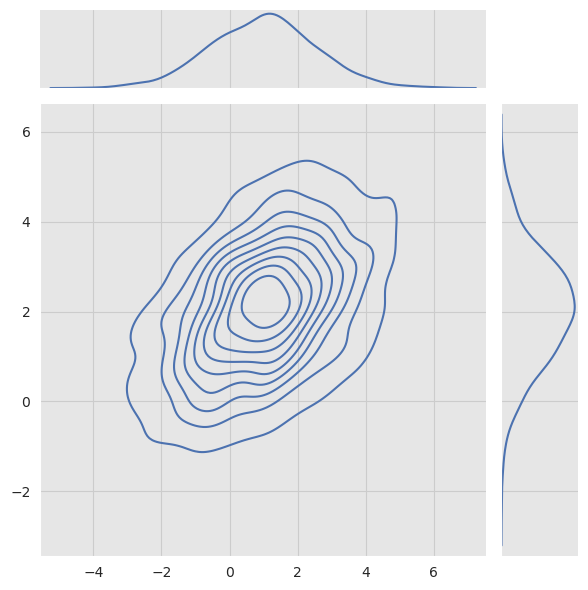

In [103]:
# Define the mean vector mu
mu = np.array([1, 2]).reshape(2, 1)

# Define the covariance matrix (it must be positive definite)
K = np.array([[2, 1],
              [1, 2]])

# Apply Cholesky decomposition of K to LL^T
L = np.linalg.cholesky(K)
L = L.T

# The variable z follows a multinormal distribution
n_samples = 100000
n_samples = 1000
x = np.random.normal(loc=0, scale=1, size=2*n_samples).reshape(2, n_samples)
z = mu + np.dot(L, x)

sns.jointplot(x=z[0], y=z[1], kind="kde");

## Following the blog article

### set the prior and posterior

So, instead of parameterizing the neural network with point estimates for weights w, we will instead parameterize it with μ’s and σ’s. 

Notice that for a lower triangular matrix there are (n2−n)/2+n=n(n+1)/2 non-zero elements. Adding the n μ’s we end up with a distribution with n(n+1)/2+n=n(n+3)/2 parameters.

By the way, we can create some prior and posterior distributions, print the number of their trainable variables, and sample from them. Note that every time we run this cell block, we get different results for the samples. See the blog post for code

In [104]:
def get_prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = tf.keras.Sequential([
        tfp.layers.DistributionLambda(lambda t: tfd.MultivariateNormalDiag(
        loc=tf.zeros(n), scale_diag=tf.ones(n)))
    ])
    return prior_model

def get_posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = tf.keras.Sequential([
        tfp.layers.VariableLayer(tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype),
        tfp.layers.MultivariateNormalTriL(n)
    ])
    return posterior_model

# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  c = np.log(np.expm1(1.))
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + 0.01*tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
  ])

## Define the model, loss function, and optimizer

To define probabilistic layers in a neural network, we use the DenseVariational() function, specifying the input and output shape, along with the prior and posterior distributions that we have previously defined. We use a sigmoid activation function to enable the network model non-linear data, along with an IndependentNormal() output layer, to capture aleatoric uncertainty, with an event shape equal to 1 (since our y is just a scalar). Regarding the kl_weight parameter, you may refer to the original paper “Weight Uncertainty in Neural Networks” for further information. For now, just take for granted that it is a scaling factor.

In [105]:
# Define the model, negative-log likelihood as the loss function
# and compile the model with the RMSprop optimizer
model = tf.keras.Sequential([
    tfp.layers.DenseVariational(input_shape=(2,), units=8,
                          make_prior_fn=get_prior,
#                          make_posterior_fn=get_posterior,
                          make_posterior_fn=posterior_mean_field,
                          kl_weight=1/x_train.shape[0]),
#                          activation='sigmoid'),
    tfp.layers.DenseVariational(units=tfp.layers.IndependentNormal.params_size(1),
                          make_prior_fn=get_prior,
#                          make_posterior_fn=get_posterior,     
                          make_posterior_fn=posterior_mean_field,
                          kl_weight=1/x_train.shape[0]),
    tfp.layers.IndependentNormal(1)
])

def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model.compile(loss=nll, optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.005))
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_variational_18 (DenseV (None, 8)                 48        
_________________________________________________________________
dense_variational_19 (DenseV (None, 2)                 36        
_________________________________________________________________
independent_normal_9 (Indepe multiple                  0         
Total params: 84
Trainable params: 84
Non-trainable params: 0
_________________________________________________________________


Let’s practice and calculate by hand the model’s parameters. The first dense variational layer has 1 input, 8 outputs and 8 biases. Therefore, there are 1⋅8+8=16 weights. Since each weight is going to be modelled by a normal distribution, we need 16 μ’s, and (162−16)/2+16=136 σ’s. The latter is just the number of elements of a lower triangular matrix 16×16. Therefore, in total we need 16+136=152 parameters.

What about the second variational layer? This one has 8 inputs (since the previous had 8 outputs), 2 outputs (the μ,σ of the independent normal distribution), and 2 biases. Therefore, it has 8×2+2=18
weights. For 18 weights, we need 18 μ’s and (182−18)/2+18=171σ’s. Therefore, in total we need 18+171=189 parameters. The tfpl.MultivariateNormalTriL.params_size(n) static function calculates the number of parameters needed to parameterize a multivariate normal distribution, so that we don’t have to bother with it.

### Train the model and make predictions

We train the model for 1000 epochs and plot the loss function vs. to confirm that the algorithm has converged.

In [106]:
print(type(x_train), type(y_train), x_train.shape, y_train.shape)

<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'> (163, 2) (163,)


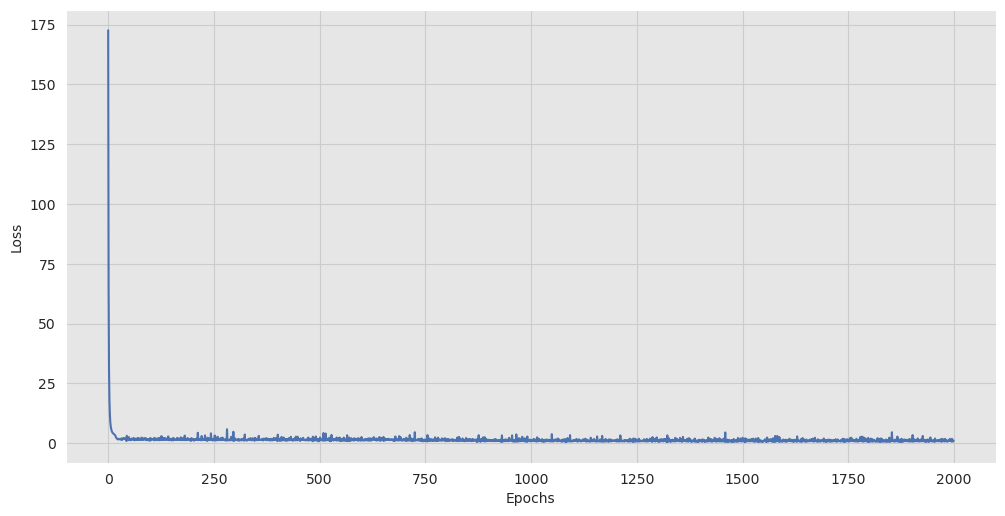

In [107]:
# Train the model for 1000 epochs
#history = model.fit(x_train, y_train, epochs=50000, verbose=0)
history = model.fit(x_train, y_train, epochs=2000, verbose=0)
plt.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss');

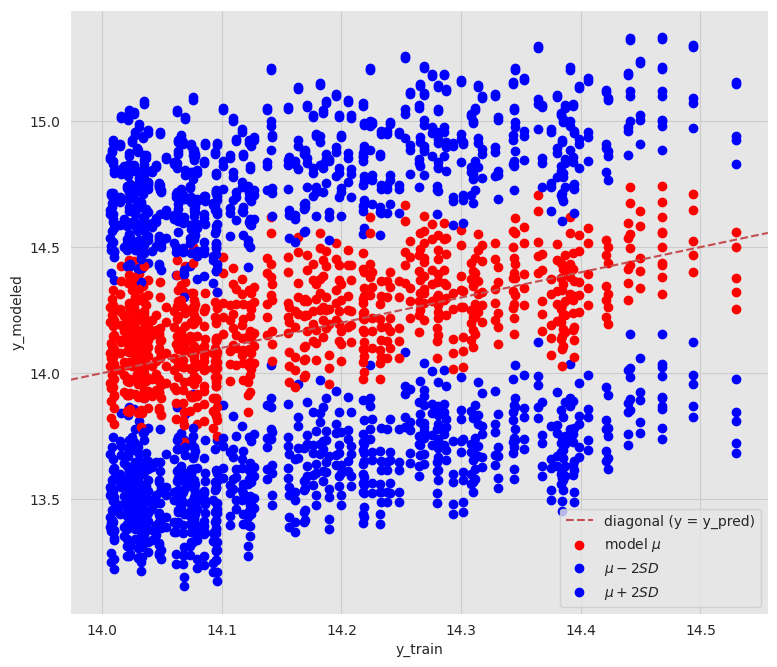

In [108]:
#plt.scatter(x_train, y_train, marker='.', alpha=0.2, label='data')
fig, ax = plt.subplots(figsize=(9, 8))
for _ in range(5):
    y_model = model(x_train)
    y_hat = y_model.mean()
    y_hat_minus_2sd = y_hat - 2 * tf.math.reduce_mean(y_model.stddev())
    y_hat_plus_2sd = y_hat + 2 *  tf.math.reduce_mean(y_model.stddev())
    plt.scatter(y_train, y_hat, color='red', label='model $\mu$' if _ == 0 else '')
    plt.scatter(y_train, y_hat_minus_2sd, color='blue', label='$\mu - 2SD$' if _ == 0 else '')
    plt.scatter(y_train, y_hat_plus_2sd, color='b', label='$\mu + 2SD$' if _ == 0 else '')
plt.xlabel('y_train')
plt.ylabel('y_modeled')
ax.axline(xy1=(14.0,14.0), slope=1, linestyle='--', color=sns_c[3], label='diagonal (y = y_pred)')
plt.legend()
plt.show()

In [109]:
print(y_model.shape)
print(y_train.shape)
print(type(y_model-y_train))
print(tf.subtract(y_model,y_train).shape)
print((y_model.stddev()).shape)
test=y_model.stddev()
print(tf.subtract(y_model,test).shape)
np.mean(y_model.stddev())

(163, 1)
(163,)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(163, 163)
(163, 1)
(163, 1)


0.30030322

In [113]:
posterior_mean = tf.math.reduce_mean(y_hat-y_train, axis=1).numpy()
posterior_std = tf.math.reduce_std(y_hat-y_train, axis=1).numpy()
print (posterior_mean.mean() , posterior_std.mean() )

-0.042973466 0.1360221


In [ ]:
fig, ax = plt.subplots(figsize=(9, 8)) 
ax.errorbar( x=yhat, y=np.array(y_test), yerr=sppd,
        fmt='o', ecolor=sns_c[9], capsize=2, label='predictions + credible intervals',)

        sns.regplot(x=vppd, y = np.array(y_test),
            color=sns_c[0], scatter=False, line_kws=dict(alpha=0.5),  truncate=False,ax=ax,label="regplot line")
        ax.axline(xy1=(14.0,14.0), slope=1, linestyle='--', color=sns_c[3], label='diagonal (y = y_pred)')
        ax.set(title='Model Predictions for Test Sample', xlabel='y', ylabel='y_pred');
        ax.legend(loc='lower right')

In [114]:
model.resolve_graph()

AttributeError: 'Sequential' object has no attribute 'resolve_graph'

In [116]:
model.sample()

AttributeError: 'Sequential' object has no attribute 'sample'